In [2]:
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import quad

import scipy
import scipy.io as sio
import scipy.fftpack

from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Any

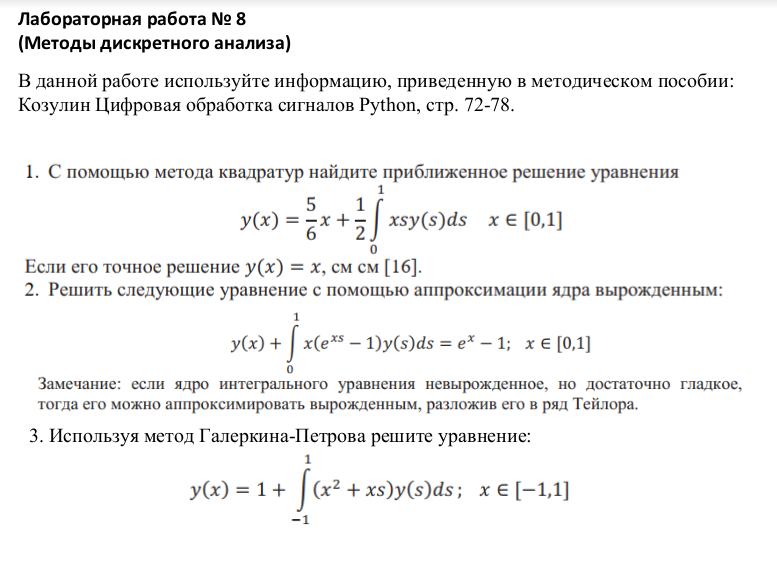

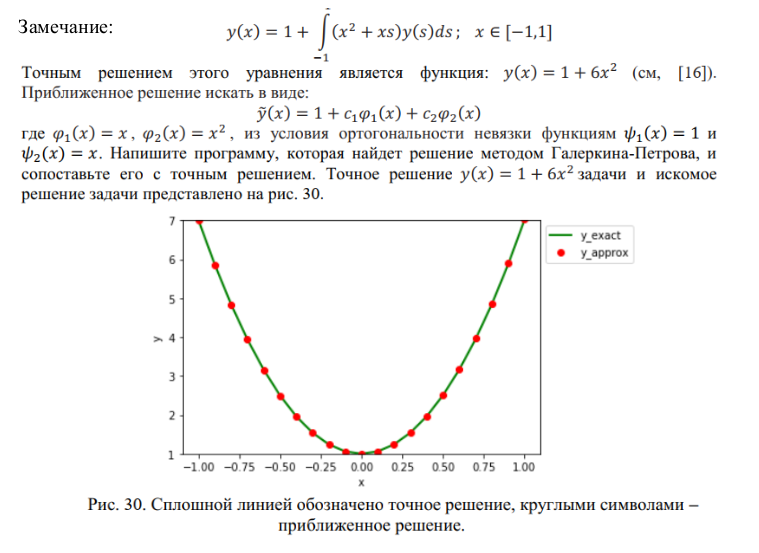

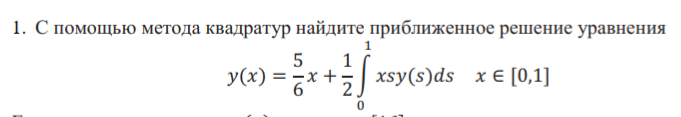

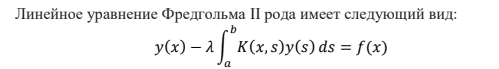

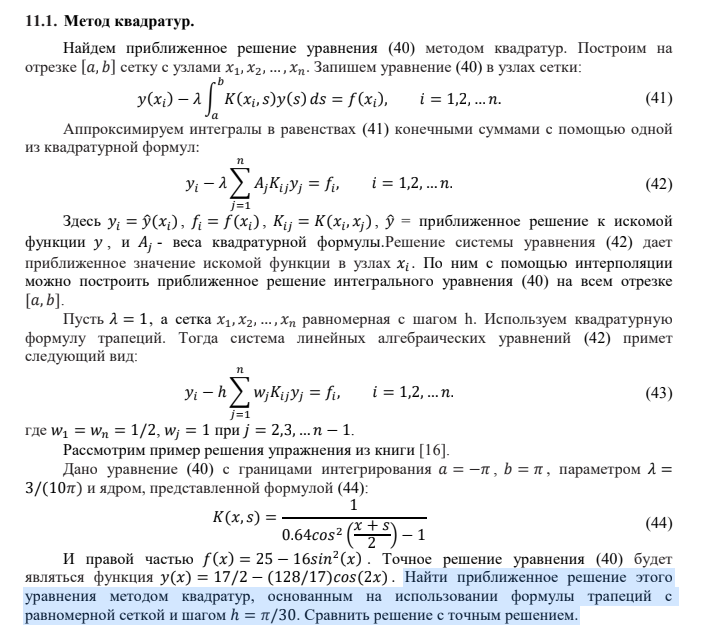

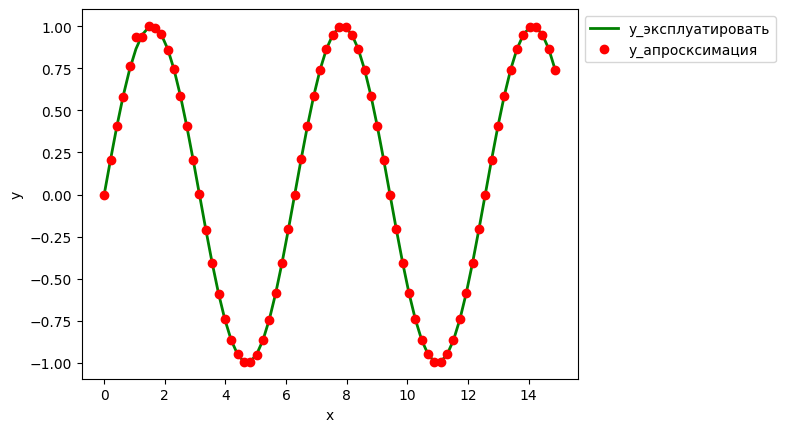

In [65]:
class FredholmSolver1:
    def __init__(self, f_exact : Callable[[Any], Any], K: Callable[[np.ndarray], np.ndarray], f: Callable[[np.ndarray], np.ndarray], a: float, b: float, h: float):
        self.K = K
        self.f = f
        self.a = a
        self.b = b
        self.h = h
        self._f_exact = f_exact
        self.x = np.arange(a, b, h).reshape(-1, 1)
        self.n = len(self.x)

    def y_exact(self, x):
        return self._f_exact(x)

    def Fred_2(self):
        wt = 1/2
        wj = 1
        A = np.zeros((self.n, self.n))

        for i in range(self.n):
            A[i, 0] = -self.h * wt * self.K(self.x[i], self.x[0])[0]
            for j in range(1, self.n-1):
                A[i, j] = -self.h * wj * self.K(self.x[i], self.x[j])[0]
            A[i, -1] = -self.h * wt * self.K(self.x[i], self.x[-1])[0]
            A[i, i] += 1

        B = self.f(self.x)[:, 0].reshape(-1, 1)

        y_approx = np.linalg.solve(A, B)
        return y_approx

    def plot_solution(self):
        y_exact = np.array([self.y_exact(xi) for xi in self.x]).reshape(self.n, 1)
        y_approx = self.Fred_2()

        plt.plot(self.x, y_exact, '-g', linewidth=2, label='y_эксплуатировать')
        plt.plot(self.x, y_approx, 'or', label='y_апросксимация')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(bbox_to_anchor=(1, 1), loc='best')
        # plt.ylim([0, max(y_exact)+2])
        plt.show()

h = np.pi / 15  # Увеличьте число узлов
a = 0
b = 15
lam = 1 / 100

y_exact = lambda x: np.sin(x)
K = lambda x1, s: np.sin(x1* s) * lam
f = lambda x1: 6 * np.sin(x1) / 6


solver2 = FredholmSolver1(y_exact, K, f, a, b, h)
solver2.plot_solution()

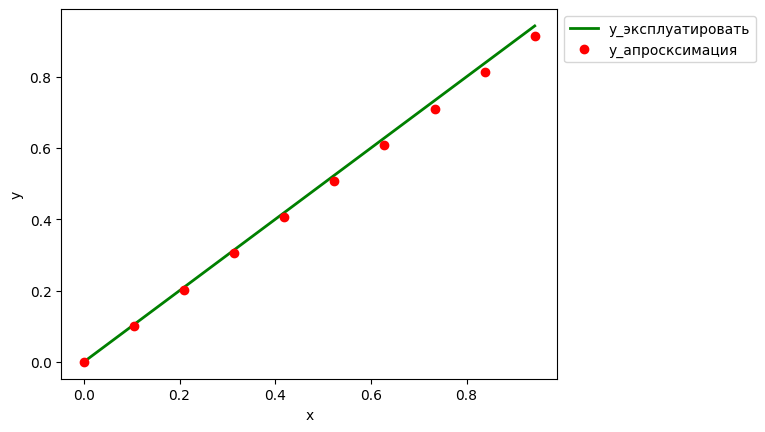

In [69]:
h = np.pi / 30
a = 0
b = 1
lam = 1/2

y_exact = lambda x: x
K = lambda x1, s: x1 * s * lam
f = lambda x1: 5 * x1 / 6

solver2 = FredholmSolver1(y_exact, K, f, a, b, h)
solver2.plot_solution()

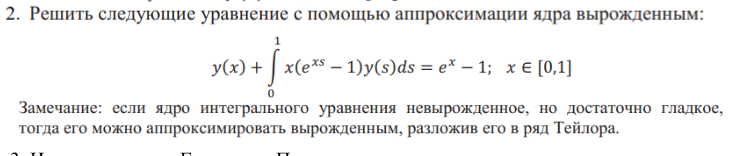

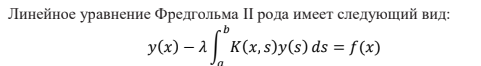

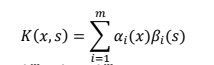

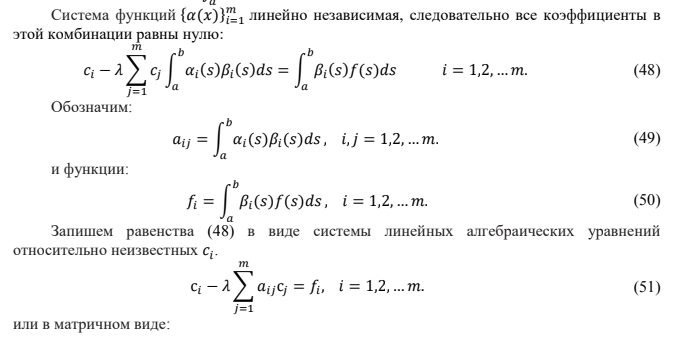

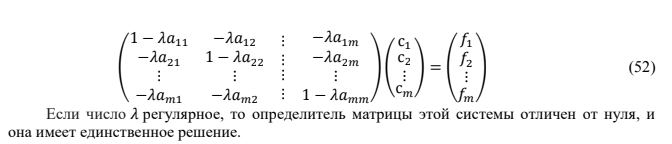

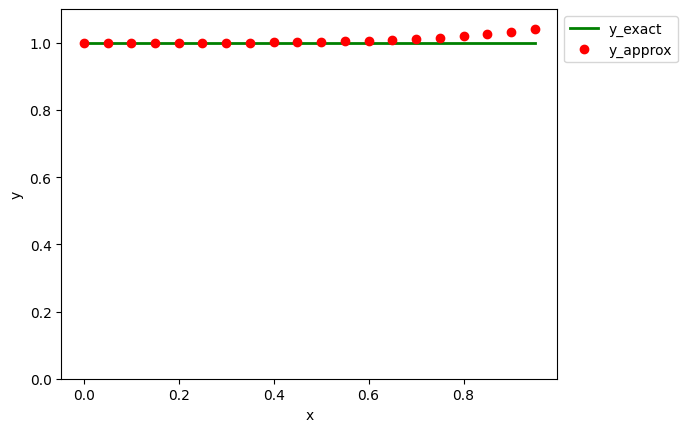

In [8]:
class FredholmSolver2:
    def __init__(self, f_exact: Callable[[float], float], a: float, b: float, h: float, Lambda: float):
        self.a = a
        self.b = b
        self.h = h
        self._f_exact = f_exact
        self.Lambda = Lambda
        self.x = np.arange(a, b, h).reshape(-1, 1)
        self.n = len(self.x)

    def alpha(self, t: float) -> list:
        return [t**2, t**3, t**4]

    def beta(self, t: float) -> list:
        return [t, 1/2*(t**2), 1/6*(t**3)]

    def f(self, t: float) -> float:
        return np.exp(t) - t

    def y_exact(self, t: float) -> float:
        return self._f_exact(t)

    def bfun(self, t: float, m: int) -> float:
        return self.beta(t)[m] * self.f(t)

    def Aijfun(self, t: float, m: int, k: int) -> float:
        return self.beta(t)[m] * self.alpha(t)[k]

    def solve(self) -> np.ndarray:
        m = len(self.alpha(0))
        M = np.zeros((m, m))
        r = np.zeros((m, 1))

        for i in range(m):
            r[i] = quad(self.bfun, self.a, self.b, args=(i,))[0]
            for j in range(m):
                M[i][j] = -self.Lambda * quad(self.Aijfun, self.a, self.b, args=(i, j))[0]

        for i in range(m):
            M[i][i] += 1

        c = np.linalg.solve(M, r)
        y_approx = np.array([self.Lambda * (c[0] * self.alpha(xi)[0] + c[1] * self.alpha(xi)[1]) + self.f(xi) for xi in self.x]).reshape(self.n, 1)
        return y_approx

    def plot_solution(self) -> None:
        y_exact = np.array([self.y_exact(xi) for xi in self.x]).reshape(self.n, 1)
        y_approx = self.solve()

        plt.plot(self.x, y_exact, '-g', linewidth=2, label='y_exact')
        plt.plot(self.x, y_approx, 'or', label='y_approx')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend('1', fontsize=12)
        plt.legend(bbox_to_anchor=(1, 1), loc='best')
        plt.ylim([0, max(y_exact) + 0.1])
        plt.show()

y_exact = lambda x: 1

solver = FredholmSolver2(y_exact, a=0, b=1, h=0.05, Lambda=-1)
solver.plot_solution()

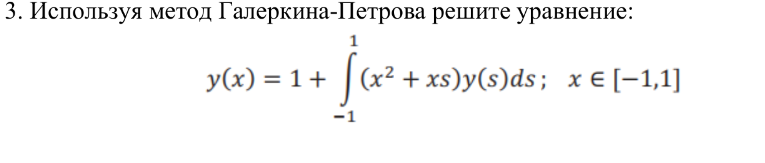

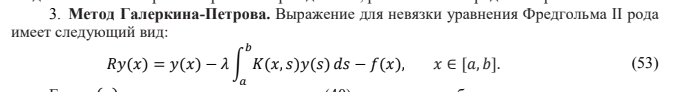

смысл в том что у нас есть базисная функция фи и функция

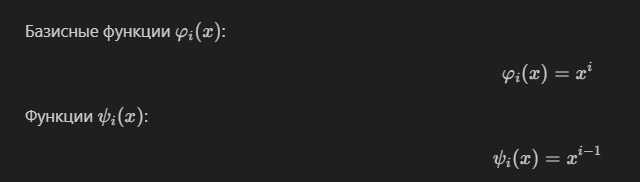

а дальше действуем по методу где нам нужно 

1 составить матрицу и вектор по следующей формуле

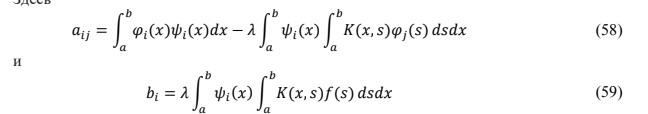

решить данную систему уравнений с коэфицентом с

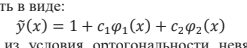

и остается апроксимизировать наше решение итого

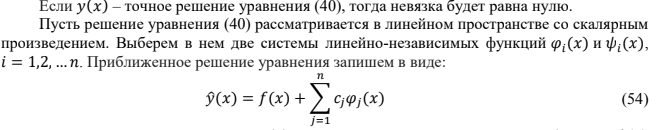

In [72]:
class FredholmSolver:
    # кол-во базисных функций n
    def __init__(self, f_exact, K, f, a, b, Lambda, n, bubnov=False):
        self.K = K
        self.f = f
        self.a = a
        self.b = b
        self._f_exact = f_exact
        self.Lambda = Lambda
        self.n = n

        self._bubnov = bubnov

    def y_exact(self, t: float) -> float:
        return self._f_exact(t)

    def fi(self, x, m):
        return np.power(x, m)

    def psi(self, x, m):
        if self._bubnov:
            return self.fi(x, m)
        return np.power(x, m-1)
    
    def integrand(self, x, s, i, j):
        return self.K(x, s) * self.fi(s, j) * self.psi(x, i)

    def __call__(self):
        x_vals = np.linspace(self.a, self.b, 100)
        B = np.zeros(self.n)
        A = np.zeros((self.n, self.n))

        for j in range(1, self.n + 1):
            B[j-1], _ = quad(lambda x: self.Lambda * self.psi(x, j) * quad(lambda s: self.f(s) * self.K(x, s), self.a, self.b)[0], self.a, self.b)
            
            for i in range(1, self.n + 1):
                A[i-1, j-1], _ = quad(lambda x: self.fi(x, j) * self.psi(x, i) - self.Lambda * quad(lambda s: self.K(x, s) * self.fi(s, j) * self.psi(x, i), self.a, self.b)[0], self.a, self.b)

        c = np.linalg.solve(A, B)
        y = self.f(x_vals) + sum(c[i] * self.fi(x_vals, i+1) for i in range(self.n))
        
        print('Сплошной линией обозначено точное решение, круглыми символами – приближенное решение.')
        plt.plot(x_vals, self.y_exact(x_vals), 'o', label='Exact Solution')
        plt.plot(x_vals, y, 'r', label='Approximate Solution')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

K = lambda x, s: x * s + x ** 2
f = lambda x: 1
# y_exact = lambda x: x ** 2 * 6 + 1

# # получаем приближенное решение уравнения
# solver = FredholmSolver(y_exact, K, f, a=-1, b=1, Lambda=1, n=2, bubnov=True)
# solver()
K = lambda x, s: x(np.exp(x*s) -1)
y_exact = lambda x: 1

# получаем приближенное решение уравнения
solver = FredholmSolver(y_exact, K, f, a=0, b=1, Lambda=0, n=2, bubnov=True)
solver()

TypeError: 'float' object is not callable

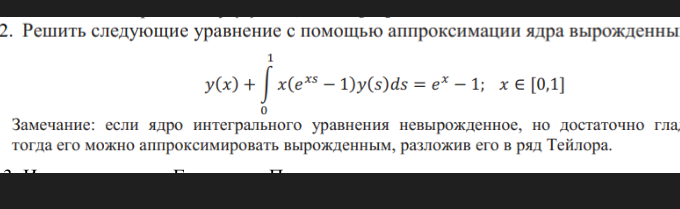

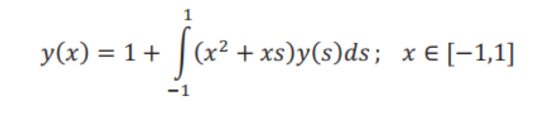

# 1 квадратуры

численное интегрирование, представляет собой группу алгоритмов, используемых для приближенного вычисления определенных интегралов. Основная идея заключается в замене подынтегральной функции на интерполяционный многочлен или другую аппроксимацию, которую легко проинтегрировать аналитически. Затем вычисляется интеграл этой аппроксимирующей функции на конечном наборе точек.


### Параметры функции:

- `K`: Функция, представляющая интегральное ядро уравнения. Принимает два аргумента, представляющих значения переменных.
- `f`: Функция, представляющая правую часть уравнения. Принимает один аргумент, представляющий значение переменной.
- `a`, `b`: Нижний и верхний пределы интегрирования соответственно.
- `h`: Шаг сетки для численного интегрирования.

### Работает:

1. Создается сетка значений переменной `x` с шагом `h` в пределах от `a` до `b`.
2. Инициализируется матрица `A` размера `(n, n)`, где `n` - количество точек на сетке.
3. Вычисляются элементы матрицы `A` с использованием интегрального ядра `K` и шагов `h`, `wt`, и `wj`.
4. Заполняется правая часть уравнения, создавая вектор `B` с использованием функции `f`.
5. Решается система линейных уравнений `Ax = B` с использованием функции `np.linalg.solve`.
6. Возвращается вектор `y_approx` с численным приближенным решением уравнения.

Найти приближенное решение этого
уравнения методом квадратур, основанным на использовании формулы трапеций с
равномерной сеткой и шагом h. Сравнить решение с точным решением. интегральное ядро
лямбда - параметр интегрального уравнения

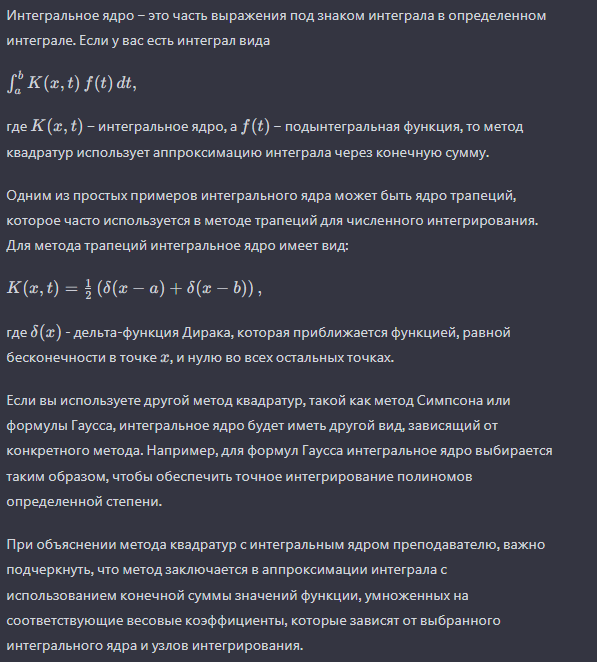
